In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
from mobo.transformation import StandardTransform
import numpy as np

In [3]:
sm = BoTorchSurrogateModelReapeat(n_var=1, n_obj=1, alpha=0.9, n_w=11)

# data normalization
transform = StandardTransform(x_bound=np.array([[0], [1]]))


def f(X):
    #sine function
    return 1.*np.sin(X*4*np.pi) + 3*X**2 -2.

#sigmoid at 0.5
def sigmoid(X):
    return 1/(1+np.exp(-10*(X-0.5)))

def noise_amplitude(X):
    return np.sin(1.5*np.pi*X)**2

def init():
    steps_size = 0.01
    X = np.arange(0, 1, steps_size).reshape(-1, 1)
    x_pred = np.arange(0, 1, steps_size).reshape(-1, 1)
    Y_true = f(X)
    sigma = 2.
    repeats = 100
    # rho = sigma*sigmoid(X)
    rho = sigma*noise_amplitude(X)
    Y_true = np.stack([Y_true] * repeats, axis=-1)
    Y_full = Y_true + np.expand_dims(rho, -1) * np.random.randn(*Y_true.shape)
    X_full = np.stack([X] * repeats, axis=-1)
    return X, X_full, Y_full, x_pred


In [4]:
from typing import List
import numpy as np
import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

from botorch.models.gp_regression import (
    HeteroskedasticSingleTaskGP,
    SingleTaskGP,
)

from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.likelihoods import LikelihoodList
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_model, fit_gpytorch_mll_torch
from botorch.models.transforms.outcome import Standardize, Log

import gpytorch
import torch

from mobo.surrogate_model.botorch_helper import CustomHeteroskedasticSingleTaskGP


def initialize_model(train_x, train_y, train_rho=None):
    train_x = torch.tensor(train_x, **tkwargs)
    train_y_mean = torch.tensor(train_y, **tkwargs) + 1e-6
    train_y_var = torch.tensor(train_rho, **tkwargs) + 1e-6

    models = []
    for i in range(train_y_mean.shape[1]):
        model = SingleTaskGP(
            train_X=train_x,     
            train_Y=train_y_mean[..., i:i+1],
            # train_Yvar=train_y_var[..., i:i+1],
            # input_transform=self.input_transform,
            # outcome_transform=Standardize(m=1),            
            outcome_transform=Log(),            
            )            
        
        models.append(model)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll, max_retries=5)

    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll, max_retries=5)
    return model


In [5]:

# STD

X, X_full, Y_full, x_pred = init()
Y = Y_full.mean(axis=-1)
Y_var = Y_full.var(axis=-1)

#noise model


#normal distributed noise
# Y += rho*np.random.normal(0, 1., Y.shape)

transform.fit(X, Y)
x, y = transform.do(X, Y)
y = Y
# rho = self.rho



sm.fit(x, y, Y_var)
noise_model = initialize_model(x, Y_var, np.zeros_like(Y_var))
# does not work
# sm.bo_model.models[0].likelihood.noise_covar.noise_model = noise_model

var = sm.evaluate(X=x_pred, noise=True)
y_pred = var['F']
X_pred, Y_pred = transform.undo(x_pred, y_pred)
Y_pred = y_pred
S_pred = var['S']
# rho_pred = var['rho_F']
rho_pred = noise_model.posterior(torch.tensor(x_pred, **tkwargs)).mean.cpu().detach().numpy()
post=sm.bo_model.posterior(torch.tensor(x_pred, **tkwargs), observation_noise=rho_pred)
post_mean = -post.mean.cpu().detach().numpy()
post_var = post.variance.cpu().detach().numpy()
rho_pred = rho_pred.squeeze()

rho statistics
mean: 1.460932124014933, std: 1.46442140846457, min: 0.0, max: 4.726097204272774


In [6]:
print(rho_pred.max())
print(rho_pred.max()**2)
print(rho_pred.max()**0.5, "\n")

print(Y_var.max())
print(Y_var.max()**2)
print(Y_var.max()**0.5, "\n")

print(Y_pred.std())
print(y_pred.std())

4.599707503725313
21.157309119826948
2.144692869323091 

4.726097204272774
22.33599478423493
2.1739588782386785 

0.8945289421231125
0.8945289421231125


0.9918585946093168 0.023638425350052443


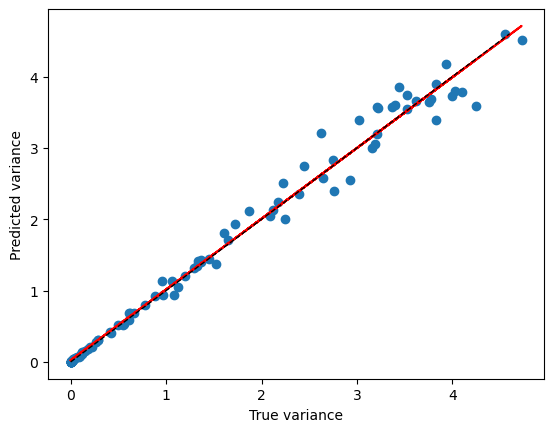

In [7]:

# rho vs rho_pred
import matplotlib.pyplot as plt
# plt.plot(X, rho)
plt.scatter(Y_var, rho_pred)
#get regression line with parameters
m, b = np.polyfit(Y_var.flatten(), rho_pred.flatten(), 1)
print(m, b)
plt.plot(Y_var, m*Y_var + b, color='red')
#diag
plt.plot([0, rho_pred.max()], [0, rho_pred.max()], 'k--', lw=1)
plt.xlabel('True variance')
plt.ylabel('Predicted variance')
 
# plt.xlim([0, rho_pred.max()])
# plt.ylim([0, rho_pred.max()])

plt.show()
 

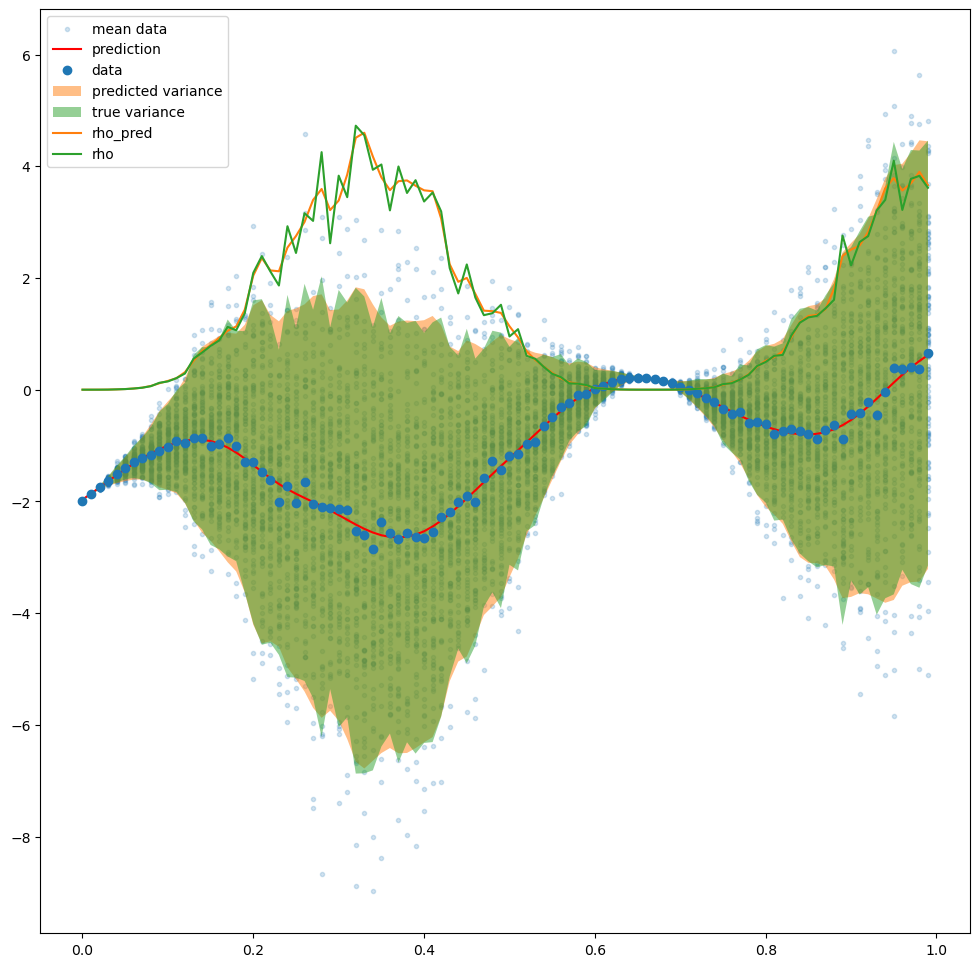

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(12, 12))

# X-full over Y-full
ax = axes
ax.scatter(X_full.flatten(), Y_full.flatten(), label='mean data', alpha=0.2, marker='.')
ax.plot(X_pred, Y_pred, label='prediction', color='r')
 
# ax = axes[0]
ax.plot(X, Y, 'o', label='data')
ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten()**0.5, Y_pred.flatten()+2*rho_pred.flatten()**0.5, alpha=0.5, label='predicted variance')
ax.fill_between(X.flatten(), Y.flatten()-2*Y_var.flatten()**0.5, Y.flatten()+2*Y_var.flatten()**0.5, alpha=0.5, label='true variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten(), Y_pred.flatten()+2*rho_pred.flatten(), alpha=0.5, label='predicted variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*Y_var.flatten(), Y_pred.flatten()+2*Y_var.flatten(), alpha=0.5, label='true variance')
ax.plot(X_pred, rho_pred, label='rho_pred')
ax.plot(X, Y_var, label='rho')
ax.legend()


plt.show()

In [9]:
# VARIANCE
X, X_full, Y_full, x_pred = init()
Y = Y_full.mean(axis=-1)
Y_var = Y_full.var(axis=-1)

#normal distributed noise
# Y += rho*np.random.normal(0, 1., Y.shape)

transform.fit(X, Y)
mu = Y.mean()
std = Y.std()
print(mu, std)
print(transform.y_scaler.mean_, transform.y_scaler.scale_)
# x, y = transform.do(X, Y)
x, y, y_var = transform.do(X, Y, Y_var)
y, y_var = Y, Y_var

print(x.mean(), x.std())
print(y.mean(), y.std())


# x,y = X,Y
# rho = self.rho

sm.fit(x, y, y_var)

var = sm.evaluate(X=x_pred, noise=True)
y_pred = var['F']
y_var_pred = var['rho_F']
X_pred, Y_pred, Y_var_pred = transform.undo(x_pred, y_pred, y_var_pred) 
Y_pred, Y_var_pred = y_pred, y_var_pred
# S_pred = var['S']
# rho_pred = var['rho_F']
rho_pred = Y_var_pred



-1.027560985661549 0.9310532054949854
[-1.02756099] [0.93105321]
0.49499999999999994 0.2886607004772212
-1.027560985661549 0.9310532054949854
rho statistics
mean: 1.5223769088724044, std: 1.5540158155641048, min: 0.0, max: 4.900104227917521


In [10]:
print(rho_pred.max())
print(rho_pred.max()**2)
print(rho_pred.max()**0.5, "\n")

print(Y_var.max())
print(Y_var.max()**2)
print(Y_var.max()**0.5, "\n")

print(Y_pred.std())
print(y_pred.std())

print(y_var.var())

4.8302361533153295
23.331181296794473
2.1977798236664494 

4.900104227917521
24.011021444455167
2.213617904679469 

0.9246570826500292
0.9246570826500292
2.3908155034731364


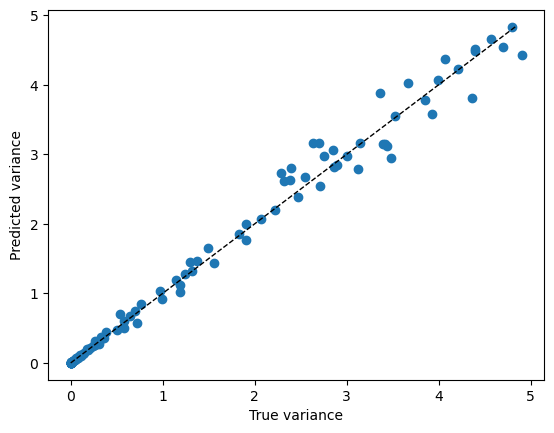

In [11]:
# rho vs rho_pred
import matplotlib.pyplot as plt
# plt.plot(X, rho)
plt.scatter(Y_var, rho_pred)
#diag
plt.plot([0, rho_pred.max()], [0, rho_pred.max()], 'k--', lw=1)
plt.xlabel('True variance')
plt.ylabel('Predicted variance')
 
# plt.xlim([0, rho_pred.max()])
# plt.ylim([0, rho_pred.max()])

plt.show()
 

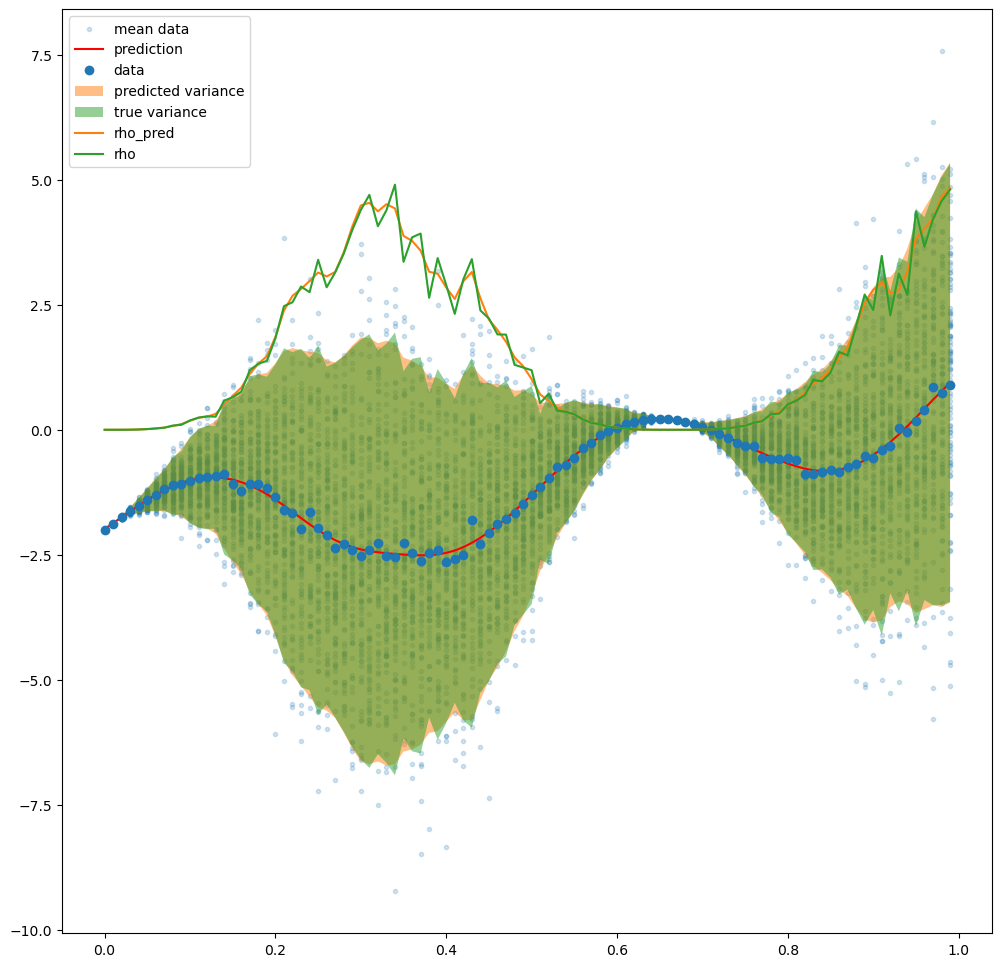

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, figsize=(12, 12))

# X-full over Y-full
ax = axes
ax.scatter(X_full.flatten(), Y_full.flatten(), label='mean data', alpha=0.2, marker='.')
ax.plot(X_pred, Y_pred, label='prediction', color='r')
 
# ax = axes[0]
ax.plot(X, Y, 'o', label='data')
ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten()**0.5, Y_pred.flatten()+2*rho_pred.flatten()**0.5, alpha=0.5, label='predicted variance')
ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*Y_var.flatten()**0.5, Y_pred.flatten()+2*Y_var.flatten()**0.5, alpha=0.5, label='true variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*rho_pred.flatten(), Y_pred.flatten()+2*rho_pred.flatten(), alpha=0.5, label='predicted variance')
# ax.fill_between(X_pred.flatten(), Y_pred.flatten()-2*Y_var.flatten(), Y_pred.flatten()+2*Y_var.flatten(), alpha=0.5, label='true variance')
ax.plot(X, rho_pred, label='rho_pred')
ax.plot(X, Y_var, label='rho')
ax.legend()


plt.show()